In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load Dataset and Fill-in the missing values (nan) with the column means

In [2]:
df_train = pd.read_csv('./dataset/cs-training.csv')
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_train.fillna(df_train.mean(), inplace=True)
print(df_train.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2. Select the a few important features using PCA(n>6) using pipeline

### 2.1 Split Data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = df_train.iloc[:, 1:].values, df_train.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

### 2.2 Use pca to decide how many features we need

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.29944594, 0.15268374, 0.12233918, 0.10093157, 0.10012884,
       0.09386178, 0.07368563, 0.05450378, 0.00173201, 0.00068753])

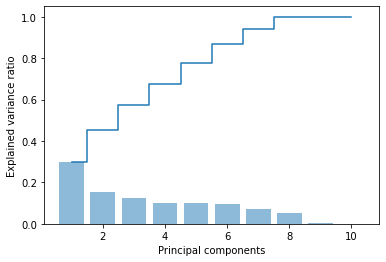

In [8]:
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

### 2.3 use pipeline to standarlize data, choose first 6 features and train the models(lr, decision tree, svm etc)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        LogisticRegression(random_state=1, C=1, solver='liblinear', multi_class='ovr'))

pipe_svm = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        SVC(random_state=1,C=1, gamma=1))
pipe_dt = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        DecisionTreeClassifier(random_state=1, max_depth=5))

pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_dt = pipe_dt.predict(X_test)

print('LR Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
print('SVM Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))
print('Decision Tree Test Accuracy: %.3f' % pipe_dt.score(X_test, y_test))

LR Test Accuracy: 0.933
SVM Test Accuracy: 0.936
Decision Tree Test Accuracy: 0.936


## 3. using GridSearch method

Because training speed of svm is pretty slow, here we choose random forest to replace svm

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# 创建随机森林分类器对象
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=6)

# 创建 Pipeline 对象，包含数据标准化和随机森林分类器
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # 数据标准化
    ('rf', rf_clf)  # 随机森林分类器
])

# 决策树分类器的 Pipeline
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),  # 数据标准化
    ('dt', DecisionTreeClassifier())  # 决策树分类器
])

# 逻辑回归分类器的 Pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),  # 数据标准化
    ('lr', LogisticRegression())  # 逻辑回归分类器
])

### 3.1 GridSearch

In [27]:
# 创建 Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6)),
    ('clf', LogisticRegression(random_state=1, C=1, solver='liblinear', multi_class='ovr'))
], memory='cachedir')

# 创建 Decision Tree Pipeline
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6)),
    ('clf', DecisionTreeClassifier(random_state=1, max_depth=5))
], memory='cachedir')

# 创建 Random Forest Pipeline
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6)),
    ('clf', RandomForestClassifier(random_state=1,n_estimators=100, n_jobs=6))
], memory='cachedir')

# 设置参数网格
params_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

params_dt = {
    'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

params_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 7, 9]
}


In [28]:
# 创建 GridSearchCV 对象
grid_lr = GridSearchCV(estimator=pipe_lr,
                       param_grid=params_lr,
                       cv=5,
                       scoring='accuracy')
grid_dt = GridSearchCV(estimator=pipe_dt,
                       param_grid=params_dt,
                       cv=5,
                       scoring='accuracy')
grid_rf = GridSearchCV(estimator=pipe_rf,
                       param_grid=params_rf,
                       cv=5,
                       scoring='accuracy')

# 在训练数据上执行网格搜索
grid_lr.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(memory='cachedir',
                                steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=6)),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=6,
                                                               random_state=1))]),
             param_grid={'clf__max_depth': [3, 5, 7, 9],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [30]:
# 输出网格搜索结果
print("Random Forest:")
for r, _ in enumerate(grid_rf.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid_rf.cv_results_['mean_test_score'][r],
             grid_rf.cv_results_['std_test_score'][r] / 2.0,
             grid_rf.cv_results_['params'][r]))

print("\nDecision Tree:")
for r, _ in enumerate(grid_dt.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid_dt.cv_results_['mean_test_score'][r],
             grid_dt.cv_results_['std_test_score'][r] / 2.0,
             grid_dt.cv_results_['params'][r]))

print("\nLogistic Regression:")
for r, _ in enumerate(grid_lr.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid_lr.cv_results_['mean_test_score'][r],
             grid_lr.cv_results_['std_test_score'][r] / 2.0,
             grid_lr.cv_results_['params'][r]))

Random Forest:
0.933 +/- 0.00 {'clf__max_depth': 3, 'clf__n_estimators': 50}
0.933 +/- 0.00 {'clf__max_depth': 3, 'clf__n_estimators': 100}
0.933 +/- 0.00 {'clf__max_depth': 3, 'clf__n_estimators': 200}
0.933 +/- 0.00 {'clf__max_depth': 5, 'clf__n_estimators': 50}
0.934 +/- 0.00 {'clf__max_depth': 5, 'clf__n_estimators': 100}
0.934 +/- 0.00 {'clf__max_depth': 5, 'clf__n_estimators': 200}
0.935 +/- 0.00 {'clf__max_depth': 7, 'clf__n_estimators': 50}
0.936 +/- 0.00 {'clf__max_depth': 7, 'clf__n_estimators': 100}
0.935 +/- 0.00 {'clf__max_depth': 7, 'clf__n_estimators': 200}
0.936 +/- 0.00 {'clf__max_depth': 9, 'clf__n_estimators': 50}
0.936 +/- 0.00 {'clf__max_depth': 9, 'clf__n_estimators': 100}
0.936 +/- 0.00 {'clf__max_depth': 9, 'clf__n_estimators': 200}

Decision Tree:
0.933 +/- 0.00 {'clf__max_depth': 1}
0.935 +/- 0.00 {'clf__max_depth': 2}
0.935 +/- 0.00 {'clf__max_depth': 3}
0.936 +/- 0.00 {'clf__max_depth': 4}
0.935 +/- 0.00 {'clf__max_depth': 5}
0.935 +/- 0.00 {'clf__max_depth'